In [1]:
import sys, os, time
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as distrib
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
import gym
import numpy as np
%matplotlib notebook
#%matplotlib tk
import matplotlib.pyplot as plt
#plt.switch_backend('Qt5Agg') #('Qt5Agg')
import foundation as fd
from foundation import nets
from foundation import util
from foundation import train

np.set_printoptions(linewidth=120)

In [11]:
args = util.NS()

args.device = 'cuda:0'
args.seed = 0

args.logdate = True
args.tblog = False
args.txtlog = False
args.saveroot = 'trained_nets'

args.dataset = 'mnist'
args.use_val = False

args.num_workers = 4
args.batch_size = 128

args.start_epoch = 0
args.epochs = 10

args.name = 'test-pointnet-super-long-opt'

args.save_model = True


now = time.strftime("%y-%m-%d-%H%M%S")
if args.logdate:
    args.name = os.path.join(args.name, now)
args.save_dir = os.path.join(args.saveroot, args.name)
print('Save dir: {}'.format(args.save_dir))

if args.tblog or args.txtlog or args.save_model:
    util.create_dir(args.save_dir)
    print('Logging in {}'.format(args.save_dir))
logger = util.Logger(args.save_dir, tensorboard=args.tblog, txt=args.txtlog)

# Set seed
if not hasattr(args, 'seed') or args.seed is None:
    args.seed = util.get_random_seed()
torch.manual_seed(args.seed)
np.random.seed(args.seed)
try:
    torch.cuda.manual_seed(args.seed)
except:
    pass

if not torch.cuda.is_available():
    args.device = 'cpu'
print('Using device {} - random seed set to {}'.format(args.device, args.seed))

Save dir: trained_nets/test-pointnet-super-long-opt/19-02-15-145035
Logging in trained_nets/test-pointnet-super-long-opt/19-02-15-145035
Using device cuda:0 - random seed set to 0


In [12]:
datasets = train.load_data(args=args)
shuffles = [True, False, False]

loaders = [DataLoader(d, batch_size=args.batch_size, num_workers=args.num_workers) for d, s in zip(datasets, shuffles)]

trainloader, testloader = loaders[0], loaders[-1]
valloader = None if len(loaders) == 2 else loaders[1]

print('traindata len={}, trainloader len={}'.format(len(datasets[0]), len(trainloader)))
if valloader is not None:
    print('valdata len={}, valloader len={}'.format(len(datasets[1]), len(valloader)))
print('testdata len={}, testloader len={}'.format(len(datasets[-1]), len(testloader)))
print('Batch size: {} samples'.format(args.batch_size))

traindata len=60000, trainloader len=469
testdata len=10000, testloader len=79
Batch size: 128 samples


In [13]:
from foundation import vision

In [14]:
# Define Model
args.total_samples = {'train': 0, 'test': 0}
epoch = 0
best_loss = None
all_train_stats = []
all_test_stats = []

xygrid = torch.from_numpy(np.mgrid[1:-1:28j,-1:1:28j]).float().to(args.device).unsqueeze(0)

class PointNetWrapper(nn.Module):
    def __init__(self, pointnet):
        super().__init__()
        self.net = pointnet
        
    def forward(self, x):
        grid = xygrid.expand(x.size(0), 2, 28, 28)
        x = torch.cat([grid, x], 1).view(x.size(0), 3, -1)
        return self.net(x)

    
# [cat, self, cat, self] -> pool

nonlin = 'prelu'
batch_norm = True

poolings = 'max'

transforms = nn.ModuleList()

din = 3

transforms.append(vision.PointSelfTransform(din=din, dout=4, hidden_dims=[8], 
                                     nonlin=nonlin, batch_norm=batch_norm, 
                                    ))
din = transforms[-1].dout

# transforms.append(vision.PointCatTransform(din=din, pool=vision.get_point_pooling(poolings), catdim=3, latent_dim=16,
#                                     enc_hidden=[8], dec_hidden=[8], nonlin=nonlin, batch_norm=batch_norm, 
#                                     ))
# din = transforms[-1].dout

transforms.append(vision.PointCatTransform(din=din, pool=vision.get_point_pooling(poolings), catdim=4, latent_dim=16,
                                    enc_hidden=[8], dec_hidden=[8], nonlin=nonlin, batch_norm=batch_norm, 
                                    ))
din = transforms[-1].dout

# transforms.append(vision.PointSelfTransform(din=din, dout=12, hidden_dims=[10], 
#                                      nonlin=nonlin, batch_norm=batch_norm, 
#                                     ))
# din = transforms[-1].dout

transforms.append(vision.PointCatTransform(din=din, pool=vision.get_point_pooling(poolings), catdim=4, latent_dim=16,
                                    enc_hidden=[16], dec_hidden=[12, 8], nonlin=nonlin, batch_norm=batch_norm, 
                                    ))
din = transforms[-1].dout

# transforms.append(vision.PointSelfTransform(din=din, dout=24, hidden_dims=[20], 
#                                      nonlin=nonlin, batch_norm=batch_norm, 
#                                     ))
# din = transforms[-1].dout

transforms.append(vision.PointCatTransform(din=din, pool=vision.get_point_pooling(poolings), catdim=4, latent_dim=20,
                                    enc_hidden=[16], dec_hidden=[8], nonlin=nonlin, batch_norm=batch_norm, 
                                    ))
din = transforms[-1].dout

# transforms.append(vision.PointCatTransform(din=din, pool=vision.get_point_pooling('max'), catdim=8, latent_dim=32,
#                                     enc_hidden=[32], dec_hidden=[24, 16], nonlin=nonlin, batch_norm=batch_norm, 
#                                     ))
# din = transforms[-1].dout

transforms.append(vision.PointSelfTransform(din=din, dout=24, hidden_dims=[20], 
                                     nonlin=nonlin, batch_norm=batch_norm, 
                                    ))
din = transforms[-1].dout





final_pool = vision.get_point_pooling(poolings)

pointnet = vision.PointNet(transforms, pool=final_pool, output_dim=10, hidden_dims=[16], nonlin=nonlin)

print(pointnet.point_str())
    
model = PointNetWrapper(pointnet)

model.to(args.device)
print(model)
print('Model has {} parameters'.format(util.count_parameters(model)))

   3 ->          [8] ->    4
   4 ->        (+ 4) ->    8
   8 ->        (+ 4) ->   12
  12 ->        (+ 4) ->   16
  16 ->         [20] ->   24
>> max <<
[16] ==> 10
PointNetWrapper(
  (net): PointNet(
    (transforms): ModuleList(
      (0): PointSelfTransform(
        (transform): Sequential(
          (0): Conv1d(3, 8, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
          (3): Conv1d(8, 4, kernel_size=(1,), stride=(1,))
        )
      )
      (1): PointCatTransform(
        (enc): Sequential(
          (0): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
          (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): PReLU(num_parameters=1)
          (3): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
          (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): PReLU(num_param

In [15]:
optim = nets.get_optimizer('rmsprop', model.parameters(), lr=4e-3, weight_decay=1e-4, momentum=0)
criterion = nn.CrossEntropyLoss()
scheduler = None#torch.optim.lr_scheduler.StepLR(optim, step_size=6, gamma=0.2)

In [16]:
def stats_callback(stats, model, sample):
    pass
stats_callback = None

In [24]:
optim.param_groups[0]['lr'] *= 0.5
optim.param_groups[0]['lr']

0.00025

In [25]:
if args.save_model:
    print('Checkpoints will be saved to {} after each epoch'.format(args.save_dir))
lr = optim.param_groups[0]['lr']

for _ in range(10):
    
    old_lr = lr
    if scheduler is not None:
        scheduler.step()
    lr = optim.param_groups[0]['lr']
    if lr != old_lr:
        print('--- lr update: {:.3E} -> {:.3E} ---'.format(old_lr, lr))

    train_stats = util.StatsMeter('lr', tau=0.1)
    train_stats.update('lr', lr)

    train_stats = train.run_cls_epoch(model, trainloader, args, mode='train', optim=optim, criterion=criterion, 
                                      epoch=epoch, print_freq=10, logger=logger, silent=True, 
                                      stats_callback=stats_callback, stats=train_stats)

    test_stats = train.run_cls_epoch(model, testloader, args, mode='test', criterion=criterion, epoch=epoch, 
                                     logger=logger, silent=True, stats_callback=stats_callback, print_freq=10)

    all_train_stats.append(train_stats)
    all_test_stats.append(test_stats)
    
    print('[ {} ] Epoch {} Train={:.3f} ({:.3f}), Test={:.3f} ({:.3f})'.format(
        time.strftime("%H:%M:%S"), epoch+1,
        train_stats['accuracy'].avg.item(), train_stats['loss'].avg.item(),
        test_stats['accuracy'].avg.item(), test_stats['loss'].avg.item(),
    ))
    
    if args.save_model:
        
        av_loss = test_stats['loss'].avg.item()
        is_best = best_loss is None or av_loss < best_loss
        if is_best:
            best_loss = av_loss
        
        path = train.save_checkpoint({
            'epoch': epoch,
            'args': args,
            'model_str': str(model),
            'model_state': model.state_dict(),
            'optim_state': optim.state_dict(),
            'all_train_stats': all_train_stats,
            'all_test_stats': all_test_stats,
            
        }, args.save_dir, is_best=is_best, epoch=epoch+1)
        #print('--- checkpoint saved to {} ---'.format(path))

    epoch += 1

print('Done')

Checkpoints will be saved to trained_nets/test-pointnet-super-long-opt/19-02-15-145035 after each epoch
[ 15:32:39 ] Epoch 51 Train=0.978 (0.070), Test=0.973 (0.084)
[ 15:32:52 ] Epoch 52 Train=0.979 (0.068), Test=0.972 (0.085)
[ 15:33:04 ] Epoch 53 Train=0.979 (0.067), Test=0.971 (0.089)
[ 15:33:16 ] Epoch 54 Train=0.980 (0.066), Test=0.973 (0.085)
[ 15:33:29 ] Epoch 55 Train=0.979 (0.066), Test=0.971 (0.091)
[ 15:33:42 ] Epoch 56 Train=0.979 (0.065), Test=0.973 (0.087)
[ 15:33:56 ] Epoch 57 Train=0.979 (0.066), Test=0.971 (0.090)
[ 15:34:08 ] Epoch 58 Train=0.980 (0.065), Test=0.971 (0.091)
[ 15:34:21 ] Epoch 59 Train=0.980 (0.065), Test=0.971 (0.091)
[ 15:34:33 ] Epoch 60 Train=0.980 (0.065), Test=0.971 (0.091)
Done


In [ ]:
# [ 14:14:40 ] Epoch 1 Train=0.571 (1.148), Test=0.383 (2.499)
# [ 14:14:58 ] Epoch 2 Train=0.721 (0.808), Test=0.270 (3.912)
# [ 14:15:17 ] Epoch 3 Train=0.794 (0.622), Test=0.616 (1.230)
# [ 14:15:36 ] Epoch 4 Train=0.839 (0.500), Test=0.678 (0.998)
# [ 14:15:55 ] Epoch 5 Train=0.880 (0.376), Test=0.777 (0.671)
# [ 14:16:14 ] Epoch 6 Train=0.899 (0.316), Test=0.821 (0.644)
# [ 14:16:34 ] Epoch 7 Train=0.908 (0.291), Test=0.643 (1.231)
# [ 14:16:53 ] Epoch 8 Train=0.912 (0.281), Test=0.458 (2.506)
# [ 14:17:12 ] Epoch 9 Train=0.919 (0.257), Test=0.733 (1.025)
# [ 14:17:31 ] Epoch 10 Train=0.922 (0.248), Test=0.813 (0.680)

In [16]:
#model.net.transforms[1].centers.squeeze()

tensor([[-0.7867, -1.0390,  1.3018,  0.0201, -0.4741, -0.5669,  0.1436,  0.7044],
        [ 0.4837,  0.8052, -0.9217, -0.1708,  0.0734, -0.5216, -0.3817, -0.9504],
        [-0.1491,  0.2678,  1.0383, -0.1553, -0.9069,  1.3123,  0.3550,  0.0281],
        [ 0.2683, -0.1890,  2.0694,  0.4253,  1.0364, -0.8385, -0.3511,  1.4212]],
       device='cuda:0', grad_fn=<SqueezeBackward0>)

<IPython.core.display.Javascript object>


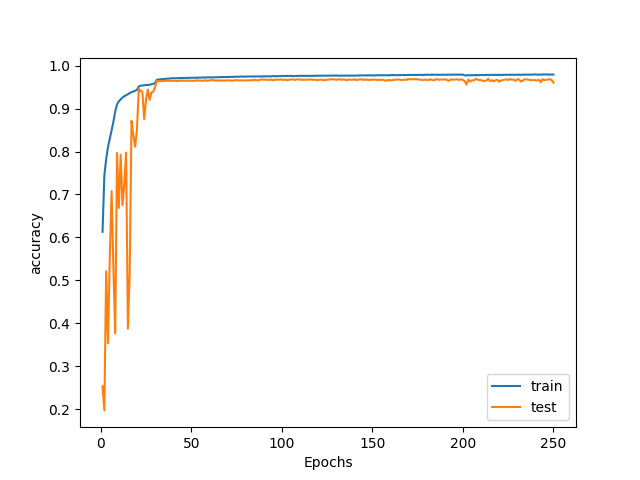

In [127]:
stat_key = 'accuracy'

figax = None
figax = util.plot_stat(all_train_stats, key=stat_key, figax=figax, label='train')
figax = util.plot_stat(all_test_stats, key=stat_key, figax=figax, label='test')
fig, ax = figax
plt.sca(ax)
plt.xlabel('Epochs')
plt.ylabel(stat_key)
plt.legend()